[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/justinhou95/DeepHedging/blob/main/deep%20efficient%20hedging.ipynb)

In [1]:
import sys
import os 
if '/content' in sys.path:
    if 'DeepHedging' in os.listdir():
        !rm -rf DeepHedging/
    !git clone https://github.com/justinhou95/DeepHedging/  
    import sys
    path = '/content/DeepHedging'
    if path not in sys.path:
        sys.path.append('/content/DeepHedging')

In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
keras = tf.keras
import utils.utils_efficient as utils_efficient
from importlib import reload 
print(tf.__version__)
reload(utils_efficient)

2.3.0


<module 'utils.utils_efficient' from 'C:\\SongyanHou\\Study\\Codes\\DeepHedging\\utils\\utils_efficient.py'>

In [2]:
reload(utils_efficient)
class EfficientHedgeCall:
    def __init__(self, po, trans_cost):
        self.trans_cost = trans_cost
        self.po = po
        self.N = 100 # time disrectization    
        self.S0 = 100.0 # initial value of the asset
        self.strike = 100
        
        self.T = 10 # maturity
        self.dt = self.T / self.N
        self.payoff_function = lambda x : 0.5*(np.abs(x-self.strike)+x-self.strike) # European call option payoff
        def ploss(payoff, outputs):
            if po == np.inf:
                self.strike_modified = 150
                loss = tf.math.reduce_max(tf.nn.relu(payoff - outputs),keepdims = True)
                self.payoff_function_modified = lambda x : 0.5*(np.abs(x-self.strike_modified)+x-self.strike_modified) 
            elif po == 0:
                self.strike_modified = 400
                loss = tf.math.sign(tf.nn.relu(payoff - outputs))
                self.payoff_function_modified = lambda x : (x-self.strike) * ((x < self.strike_modified) & (x > self.strike))
            elif po == 1:
                self.strike_modified = 200
                loss = (tf.nn.relu(payoff - outputs))**po
                self.payoff_function_modified = lambda x : (x-self.strike) * (x > self.strike_modified) 
            elif po < 1:
                self.strike_modified = 200
                loss = (tf.nn.relu(payoff - outputs) + 1e-6)**po - 1e-6**po
                self.payoff_function_modified = None                # to be added 
            else:
                self.strike_modified = 200
                loss = (tf.nn.relu(payoff - outputs))**po
                self.payoff_function_modified = None                # to be added 
            return loss
        ploss(0.,0.)
        self.ploss = ploss

    def generate_data(self):        
        self.m = 1 # dimension of price
        self.mu = 0.08
        self.sigma = 0.3
        self.Ktrain = 10**5
        self.price_path, self.time_grid = utils_efficient.simulate_GBM(self.m,self.Ktrain,self.N,self.T,\
                                                             self.mu,self.sigma,self.S0, 'equi-exp')
        self.price_path_EMM, _ = utils_efficient.simulate_GBM(self.m,self.Ktrain,self.N,self.T,\
                                                             0,self.sigma,self.S0, 'equi-exp')
        self.payoff = self.payoff_function(self.price_path[:,-1]) 
            
        

        if self.po in [np.inf, 1, 0]:
            self.payoff_modified = self.payoff_function_modified(self.price_path[:,-1]) 
            self.rep_price = self.payoff_function(self.price_path_EMM[:,-1]).mean() 
            self.initial_wealth = self.payoff_function_modified(self.price_path_EMM[:,-1]).mean() 
            self.delta_output, self.delta_path, self.option_path = utils_efficient.delta_hedge(self.price_path,\
                   self.payoff_modified, self.T,[self.strike, self.strike_modified],self.sigma,self.po,self.time_grid)
            self.initial_wealth = self.option_path[0,0,0]
            if self.trans_cost:
                self.delta_cost_output, self.hedge_cost_path, _ = utils_efficient.delta_hedge_cost(self.price_path,\
                 self.payoff,model.T,[self.strike, self.strike_modified],self.sigma,self.po,self.time_grid)
        else:
            self.rep_price = self.payoff_function(self.price_path_EMM[:,-1]).mean() 
            self.initial_wealth = 0.7*self.rep_price
    def plot_payoff(self):
        print(f"replicate wealth: {self.rep_price:{1}.{4}}")           # real premium
        print(f"initial wealth: {self.initial_wealth:{1}.{4}}")           # real premium
        print(f"ratio: {self.initial_wealth / self.rep_price:{1}.{4}}")
        plt.figure(figsize = [8,3])
        if self.po in [np.inf, 1, 0]:
            plt.scatter(self.price_path[:,-1,0], self.delta_output[:,0], s = 1, alpha = 0.5, label = 'delta payoff')
        plt.scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'payoff')
        if self.po in [np.inf, 1, 0]:
            plt.scatter(self.price_path[:,-1,0], self.payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff')
        plt.legend()
        plt.grid()
        plt.show()
        
    def build_model(self):
        self.model_hedge, self.Network0, self.Networks = build_dynamic_cost(self.m, self.N, self.trans_cost, self.initial_wealth, self.ploss, self.po)
    
    def prepare_data(self):    
        self.split = int(self.Ktrain/2)
        self.xtrain = [self.price_path[:self.split], self.payoff[:self.split]]  # input be price_path
        self.ytrain = self.payoff[:self.split]*0  # output be payoff
        self.xtest = [self.price_path[self.split:], self.payoff[:self.split]]  # input be price_path
        self.ytest = self.payoff[self.split:]*0  # output be payoff      
    def train(self, epochs):
        def zeroloss(y_true, y_predict):
            return tf.reduce_sum(y_predict*0)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
        self.model_hedge.compile(optimizer = optimizer,loss=zeroloss) # specify the expected shortfall
        self.model_hedge.fit(x=self.xtrain,y=self.ytrain, epochs=epochs,verbose=True,batch_size=256) # train the model
    def predict(self):
        self.hedge_output_train = self.model_hedge.predict(self.xtrain) # compute the output (deep replicate payoff) with trained model 
        self.hedge_output_test = self.model_hedge.predict(self.xtest) # compute the output (deep replicate payoff) with trained model
        trainloss = tf.reduce_mean(self.ploss(self.payoff[:self.split], self.hedge_output_train)).numpy()
        testloss = tf.reduce_mean(self.ploss(self.payoff[self.split:], self.hedge_output_test)).numpy()
        print('ploss')
        if self.po not in [0,np.inf]:
            trainloss = trainloss**(1/self.po)
            testloss = testloss**(1/self.po)
        print('train: ',trainloss)
        print('test: ',testloss)
        if self.po in [np.inf, 1, 0]:
            print('delta: ',tf.reduce_mean(self.ploss(self.payoff, self.delta_output)).numpy())
        if self.trans_cost:
            pic = 4
            print('delta(cost): ',tf.reduce_mean(self.ploss(self.payoff, self.delta_cost_output)).numpy())
        else:
            pic = 3
        f,p = plt.subplots(1,pic, figsize = [20,5], sharey = True, sharex = True)
        p[0].scatter(self.price_path[self.split:,-1,0], self.hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')
        p[1].scatter(self.price_path[:self.split,-1,0], self.hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train') 
        if self.po in [np.inf, 1, 0]:
            p[2].scatter(self.price_path[:,-1,0], self.delta_output[:,0], s = 1, alpha = 0.5, label = 'delta_hedging')   
        if self.trans_cost:
            p[3].scatter(self.price_path[:,-1,0], self.delta_cost_output[:,0], s = 1, alpha = 0.5, label = 'delta_hedging (cost)')
            
        for i in range(pic):
            p[i].scatter(self.price_path[:,-1,0], self.payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
            if self.po in [np.inf, 1, 0]:
                p[i].scatter(self.price_path[:,-1,0], self.payoff_modified[:,0], s = 1, alpha = 0.5, label = 'modified payoff') 
            p[i].legend()
            p[i].grid()
        
            plt.xlim(0,600)
            plt.ylim(-100,500)
        plt.show()
    def compare_strategy(self):
        f,p = plt.subplots(1,5,figsize = [20,5])
        for i in range(5):
            n = 20*i + 10
            pr = np.linspace(1,500,100)[:,None]  # tf.tensor of different price 

            he = self.Networks[n](tf.math.log(pr)) # the stategy network 
            p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy
            if self.po == 0:
                BS_func = utils_efficient.BS0
            elif self.po == 1:
                BS_func = utils_efficient.BS1
            elif self.po == np.inf:
                BS_func = utils_efficient.BSinf   
            else:
                print('ERROR')
            _ , delta = BS_func(self.T - self.time_grid[n], pr, [self.strike,self.strike_modified], self.sigma)
            p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
            p[i].title.set_text(f"At time: {self.time_grid[n]:{1}.{4}}")
            p[i].legend()
            p[i].grid()
        plt.show()

In [3]:
alpha = 10
beta = 10
def build_dynamic_cost(m, N, trans_cost, initial_wealth, ploss, po):
    
    L = 3 # number of layers in strategy
    n = m + 20  # nodes in the first but last layers
    Networks = utils_efficient.build_network(m, n , L, N)
    Network0 = keras.layers.Dense(1, use_bias=False)

    price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
    benchmark_hedge = keras.Input(shape=(N+1,m))   # V_{t}; t=0,..,N+1; (batch, N+1, m)
    payoff = keras.Input(shape=(1))
    inputs = [price, payoff]
    price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
#     premium = Network0(tf.ones_like(price[:,0,:1])) # premium; (batch, 1)
    premium = initial_wealth
    HEDGE = [None]*(N+1)
    HEDGE[0] = tf.zeros_like(price[:,0,:])
    STRATEGY = [None]*N
    ADMISSIBLE = tf.zeros_like(price[:,0,:])
    cost_all = 0
    for j in range(N):
        I = tf.math.log(price[:,j,:])
        STRATEGY[j] = Networks[j](I) # H_{t} = nn(S_{t}); (batch, m)
        cost = 0
        if trans_cost and j > 0: 
            cost = 0.001*((STRATEGY[j]- STRATEGY[j-1])*price[:,j,:])**2
            cost_all += cost
        HEDGE[j+1] = HEDGE[j] + STRATEGY[j] * price_difference[:,j,:] - cost # dX_{t} = H_{t}dS_{t}; (batch, m)
        ADMISSIBLE = tf.math.minimum(ADMISSIBLE, HEDGE[j+1] + premium)
    outputs = premium + tf.math.reduce_sum(HEDGE[-1],axis = -1, keepdims = True) # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)    
    model_hedge = keras.Model(inputs = inputs, outputs=outputs)

# Define LOSS

    loss1 = ploss(payoff, outputs)
    loss1 = tf.reduce_mean(loss1)
    if po not in [0,np.inf]:
        loss1 = loss1 ** (1/po)
    model_hedge.add_loss(loss1) 
    model_hedge.add_metric(loss1, name='p-loss')

    loss2 = tf.nn.relu(-ADMISSIBLE)*alpha
    loss2 = tf.reduce_mean(loss2)
    model_hedge.add_loss(loss2) 
    model_hedge.add_metric(loss2, name='0-ad-loss')
    
    if trans_cost:
        loss_cost = tf.reduce_mean(cost_all)
        model_hedge.add_metric(loss_cost, name='tran_cost')
    
#     loss3 = tf.nn.relu((outputs - payoff)*beta)
#     loss3 = tf.reduce_mean(loss3)
#     model_hedge.add_loss(loss3) 
#     model_hedge.add_metric(loss3, name='up-ad-loss')
 
    
    return model_hedge, Network0, Networks


replicate wealth: 35.89
initial wealth: 28.48
ratio: 0.7935


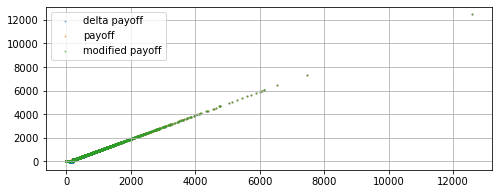

Epoch 1/30
196/196 [==============================] - 3s 16ms/step - loss: 245.9276 - p-loss: 66.7294 - 0-ad-loss: 178.5510
Epoch 2/30
196/196 [==============================] - 4s 18ms/step - loss: 51.0957 - p-loss: 40.2553 - 0-ad-loss: 10.8103: 2s - loss: 55.2399 - p-loss: 43.9781 - 0-ad-loss: 11.2 - ETA: 3s - loss: 51.6185 - p-loss: 40.09 - ETA: 1s - loss: 52.7109 - p-l
Epoch 3/30
196/196 [==============================] - 3s 17ms/step - loss: 39.3216 - p-loss: 31.2543 - 0-ad-loss: 8.0481
Epoch 4/30
196/196 [==============================] - 3s 16ms/step - loss: 35.5333 - p-loss: 28.2807 - 0-ad-loss: 7.2925
Epoch 5/30
196/196 [==============================] - 3s 16ms/step - loss: 35.0778 - p-loss: 27.5277 - 0-ad-loss: 7.5708
Epoch 6/30
196/196 [==============================] - 3s 16ms/step - loss: 34.1709 - p-loss: 26.6884 - 0-ad-loss: 7.4684
Epoch 7/30
196/196 [==============================] - 3s 16ms/step - loss: 33.5850 - p-loss: 26.6360 - 0-ad-loss: 6.9465 1s
Epoch 8/30
196/1

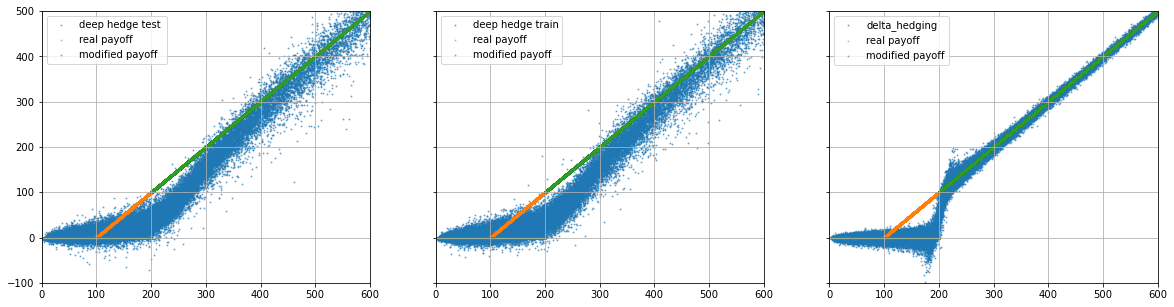

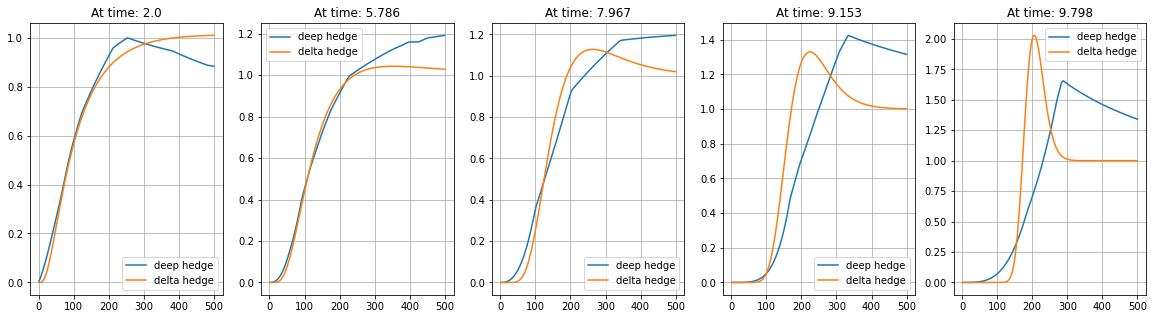

In [6]:
model = EfficientHedgeCall(1, False)
model.generate_data()
model.plot_payoff()
model.build_model()
model.prepare_data()
model.train(30)
model.predict()
model.compare_strategy()

replicate wealth: 36.79
initial wealth: 25.76
ratio: 0.7


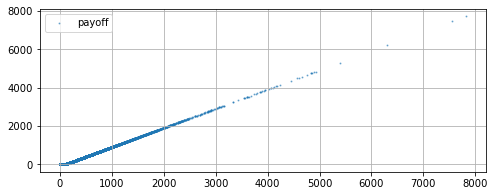

Epoch 1/30
196/196 [==============================] - 4s 19ms/step - loss: 292.1903 - p-loss: 92.1469 - 0-ad-loss: 199.2974
Epoch 2/30
196/196 [==============================] - 4s 20ms/step - loss: 68.8261 - p-loss: 52.0270 - 0-ad-loss: 16.8231: 2s - loss: 74.0848 - p-loss: 55.6594 - ETA: 1s - loss: 71.0845 - p-loss: 53.4720 - 0-ad- - ETA: 0s - loss: 69.7677 - p-loss: 52.6904 - 0-ad-los
Epoch 3/30
196/196 [==============================] - 4s 20ms/step - loss: 59.1562 - p-loss: 44.4442 - 0-ad-loss: 14.6891: 3s - loss: 59.9040 - p-loss: - ETA: 2s - loss: 59.0630 - p-loss: 44.4715 - 0-ad-loss: 14. - ETA: 1s - loss: 59.3148 - p-loss: 44.5998 - 0-ad-loss: 14.715 - ETA: 1s - loss: 59.3683 - p-loss: 4 - ETA: 0s - loss: 59.1646 - p-loss: 44.4361 - 0-ad-loss: 14.72
Epoch 4/30
196/196 [==============================] - 4s 20ms/step - loss: 57.6941 - p-loss: 43.5397 - 0-ad-loss: 14.1712: 3s - loss: 59.7799 - p-loss: 45.1998 - 0-ad-loss: 14. - ETA: 3s - loss: 60.4178 - p-loss: 45.4210 - 0-ad-los

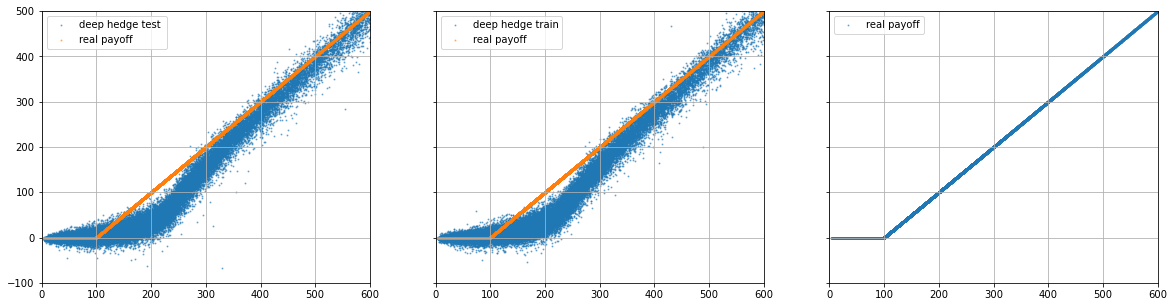

In [7]:
model = EfficientHedgeCall(1.1, False)
model.generate_data()
model.plot_payoff()
model.build_model()
model.prepare_data()
model.train(30)
model.predict()

replicate wealth: 36.37
initial wealth: 25.46
ratio: 0.7


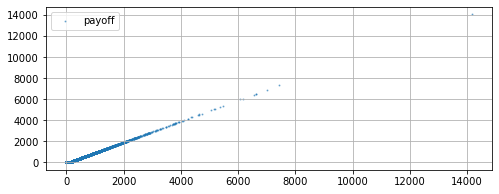

Epoch 1/100
196/196 [==============================] - 3s 13ms/step - loss: 597.8291 - p-loss: 200.7235 - 0-ad-loss: 395.6186
Epoch 2/100
196/196 [==============================] - 3s 14ms/step - loss: 165.6293 - p-loss: 128.0141 - 0-ad-loss: 37.6911: 0s - loss: 164.0106 - p-loss: 127.5192 - 0-ad-loss: 36
Epoch 3/100
196/196 [==============================] - 3s 14ms/step - loss: 135.3344 - p-loss: 104.2467 - 0-ad-loss: 31.0123
Epoch 4/100
196/196 [==============================] - 3s 14ms/step - loss: 119.5783 - p-loss: 94.1319 - 0-ad-loss: 25.3721
Epoch 5/100
196/196 [==============================] - 3s 14ms/step - loss: 94.6941 - p-loss: 73.0427 - 0-ad-loss: 21.7129
Epoch 6/100
196/196 [==============================] - 3s 14ms/step - loss: 106.1190 - p-loss: 81.3344 - 0-ad-loss: 24.9762
Epoch 7/100
196/196 [==============================] - 3s 14ms/step - loss: 97.8099 - p-loss: 76.1546 - 0-ad-loss: 21.6340
Epoch 8/100
196/196 [==============================] - 3s 15ms/step - loss

196/196 [==============================] - 3s 17ms/step - loss: 93.5681 - p-loss: 75.4000 - 0-ad-loss: 18.1711: 2s - loss: 94.7907 - p-loss: 76.7016 - 0-ad-loss: 1 - ETA: 1s - loss: 93.8868 - p-loss: 75.8823 - 0-ad-loss: 1 - ETA: 1s - loss: 93.7997 - p-loss: 75.6264 - 0-ad-loss - ETA: 0s - loss: 94.0932 - p-loss: 75.6538 - 0-ad-loss: 18. - ETA: 0s - loss: 93.7305 - p-loss: 75.4001 - 0-ad-loss: 1 - ETA: 0s - loss: 93.1203 - p-loss: 75.0632 - 0-ad-loss: 1
Epoch 47/100
196/196 [==============================] - 3s 16ms/step - loss: 91.8251 - p-loss: 73.8097 - 0-ad-loss: 17.9952: 1s - loss: 94.9020 - p-loss: 76.2
Epoch 48/100
196/196 [==============================] - 3s 16ms/step - loss: 86.0134 - p-loss: 69.8089 - 0-ad-loss: 16.2459: 2s - loss: 
Epoch 49/100
196/196 [==============================] - 3s 17ms/step - loss: 83.8351 - p-loss: 68.0065 - 0-ad-loss: 15.8414: 2s - loss: 84.1840 - ETA: 0s - loss: 84.2541 - p-loss: 68.3800 - 0-ad-loss:
Epoch 50/100
196/196 [=======================

196/196 [==============================] - 4s 18ms/step - loss: 71.5277 - p-loss: 56.5280 - 0-ad-loss: 15.0050: 3s - loss: 69.4851 - p-loss: 54. - ETA: 1s - loss: 72.2891 - p-loss: 56.97 - ETA: 0s - loss: 71.5401 - p-loss: 56.4967 - 0-ad-loss: 15.043
Epoch 81/100
196/196 [==============================] - 3s 16ms/step - loss: 71.1216 - p-loss: 56.4166 - 0-ad-loss: 14.7644: 1s - loss: 69.6324 - p-loss: 54.7788 - 0-ad-l - ETA: 0s - loss: 71.4100 - p-loss: 56.3226 - 0-ad- - ETA: 0s - loss: 71.1720 - p-loss: 56.3745 - 0-ad-loss: 14.
Epoch 82/100
196/196 [==============================] - 3s 16ms/step - loss: 70.7684 - p-loss: 55.9457 - 0-ad-loss: 14.8029: 1s - loss: 73.7026 - p-l
Epoch 83/100
196/196 [==============================] - 3s 16ms/step - loss: 62.5083 - p-loss: 49.1926 - 0-ad-loss: 13.3454: 2s - loss: 71.1067 - p-loss: 56.4296 - 0-ad-loss: 14 - ETA: 2s - loss: 68.9520 - p-loss: 54.7098 - 0-ad-loss:  - ETA: 2s - loss: 66.8943 - p-loss: 53.4538 - 0-ad-loss: - ETA: 1s - loss: 64.8

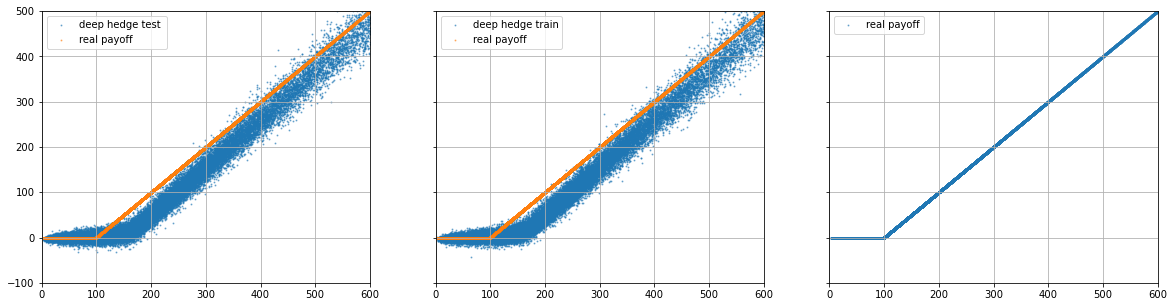

In [4]:
model = EfficientHedgeCall(5, False)
model.generate_data()
model.plot_payoff()
model.build_model()
model.prepare_data()
model.train(100)
model.predict()

replicate wealth: 36.83
initial wealth: 25.78
ratio: 0.7


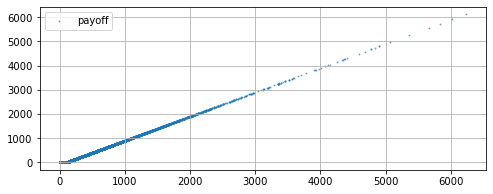

Epoch 1/30
196/196 [==============================] - 3s 15ms/step - loss: 213.3775 - p-loss: 37.5594 - 0-ad-loss: 175.2226: 0s - loss: 294.2872 - p-loss: 36.5618 - 0-
Epoch 2/30
196/196 [==============================] - 3s 16ms/step - loss: 36.1757 - p-loss: 34.1073 - 0-ad-loss: 2.0820
Epoch 3/30
196/196 [==============================] - 3s 16ms/step - loss: 31.4791 - p-loss: 28.4247 - 0-ad-loss: 3.0402
Epoch 4/30
196/196 [==============================] - 3s 17ms/step - loss: 31.5064 - p-loss: 27.7754 - 0-ad-loss: 3.7176
Epoch 5/30
196/196 [==============================] - 3s 17ms/step - loss: 29.7394 - p-loss: 26.1292 - 0-ad-loss: 3.6030
Epoch 6/30
196/196 [==============================] - 3s 17ms/step - loss: 30.1573 - p-loss: 26.8248 - 0-ad-loss: 3.3483
Epoch 7/30
196/196 [==============================] - 3s 17ms/step - loss: 29.5066 - p-loss: 26.2951 - 0-ad-loss: 3.2270
Epoch 8/30
196/196 [==============================] - 3s 17ms/step - loss: 28.0950 - p-loss: 25.2503 - 0-a

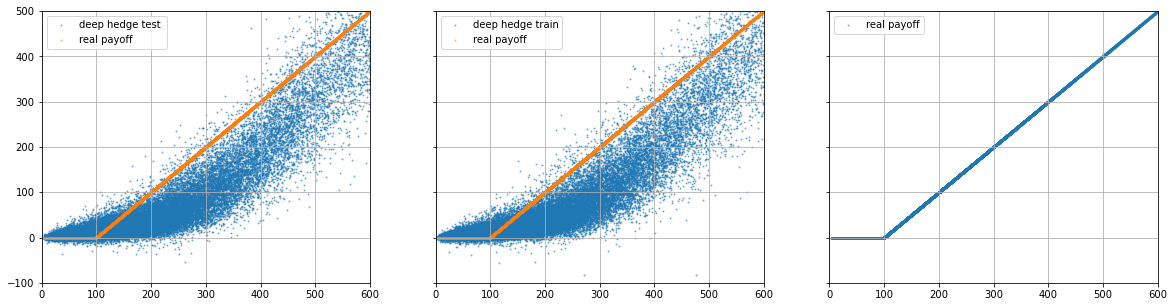

In [5]:
model = EfficientHedgeCall(0.85, False)
model.generate_data()
model.plot_payoff()
model.build_model()
model.prepare_data()
model.train(30)
model.predict()

replicate wealth: 36.4
initial wealth: 25.48
ratio: 0.7


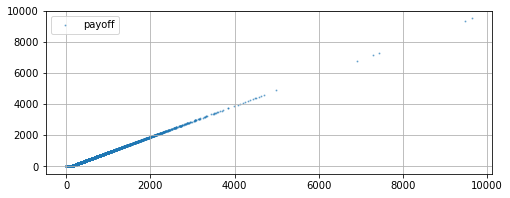

Epoch 1/30
196/196 [==============================] - 3s 15ms/step - loss: 196.4899 - p-loss: 5.8715 - 0-ad-loss: 189.9507
Epoch 2/30
196/196 [==============================] - 3s 17ms/step - loss: 6.3241 - p-loss: 6.3058 - 0-ad-loss: 0.0230
Epoch 3/30
196/196 [==============================] - 4s 18ms/step - loss: 6.2070 - p-loss: 6.1503 - 0-ad-loss: 0.0498
Epoch 4/30
196/196 [==============================] - 4s 18ms/step - loss: 6.0881 - p-loss: 6.0149 - 0-ad-loss: 0.0742 1s - loss: 6.1
Epoch 5/30
196/196 [==============================] - 4s 20ms/step - loss: 5.9591 - p-loss: 5.8596 - 0-ad-loss: 0.1018
Epoch 6/30
196/196 [==============================] - 4s 18ms/step - loss: 5.8148 - p-loss: 5.7141 - 0-ad-loss: 0.1026 0s - loss: 5.8139 - p-loss: 5.7121 - 0-ad-loss: 0. - ETA: 0s - loss: 5.8148 - p-loss: 5.7141 - 0-ad-loss: 0.10
Epoch 7/30
196/196 [==============================] - 4s 19ms/step - loss: 5.7383 - p-loss: 5.6359 - 0-ad-loss: 0.1012 0s - loss: 5.7782 - p-loss: 
Epoch 8/

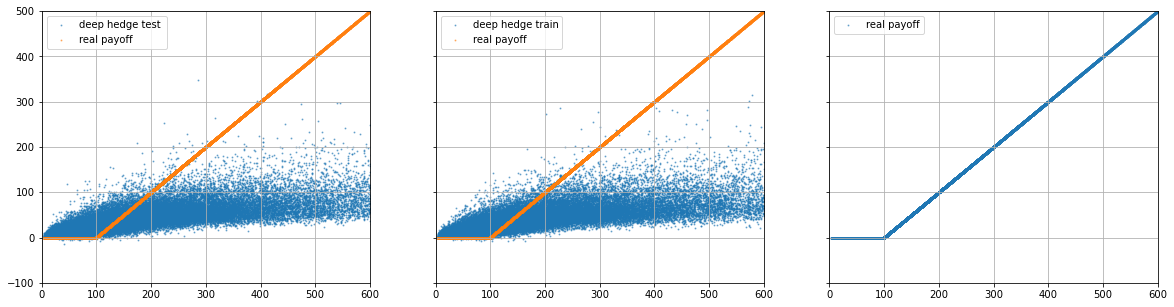

In [6]:
model = EfficientHedgeCall(0.5, False)
model.generate_data()
model.plot_payoff()
model.build_model()
model.prepare_data()
model.train(30)
model.predict()

Epoch 1/30
196/196 [==============================] - 9s 48ms/step - loss: 179.9996 - p-loss: 119.5194 - 0-ad-loss: 60.3687
Epoch 2/30
196/196 [==============================] - 10s 53ms/step - loss: 167.7366 - p-loss: 109.2538 - 0-ad-loss: 58.3826
Epoch 3/30
196/196 [==============================] - 12s 61ms/step - loss: 164.8078 - p-loss: 107.6693 - 0-ad-loss: 57.1478
Epoch 4/30
196/196 [==============================] - 16s 79ms/step - loss: 158.2149 - p-loss: 100.4487 - 0-ad-loss: 57.6342
Epoch 5/30
196/196 [==============================] - 23s 119ms/step - loss: 156.1530 - p-loss: 101.4758 - 0-ad-loss: 54.7459
Epoch 6/30
196/196 [==============================] - 21s 105ms/step - loss: 158.1530 - p-loss: 99.4095 - 0-ad-loss: 58.6766
Epoch 7/30
196/196 [==============================] - 23s 117ms/step - loss: 150.2987 - p-loss: 96.9058 - 0-ad-loss: 53.4165
Epoch 8/30
196/196 [==============================] - 18s 89ms/step - loss: 160.7065 - p-loss: 100.6374 - 0-ad-loss: 59.8949


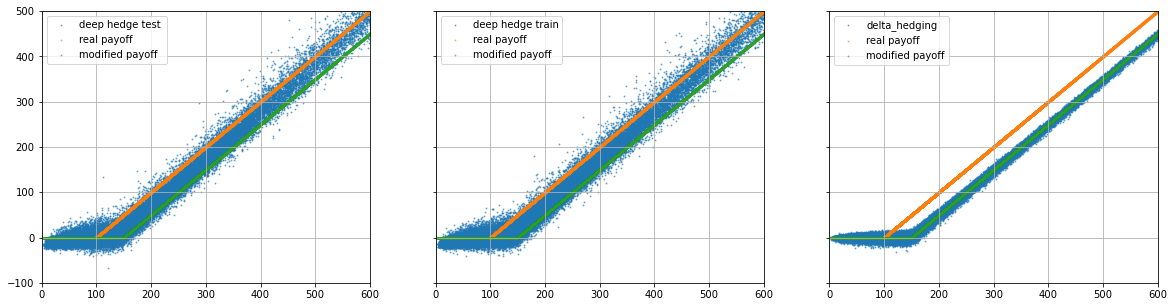

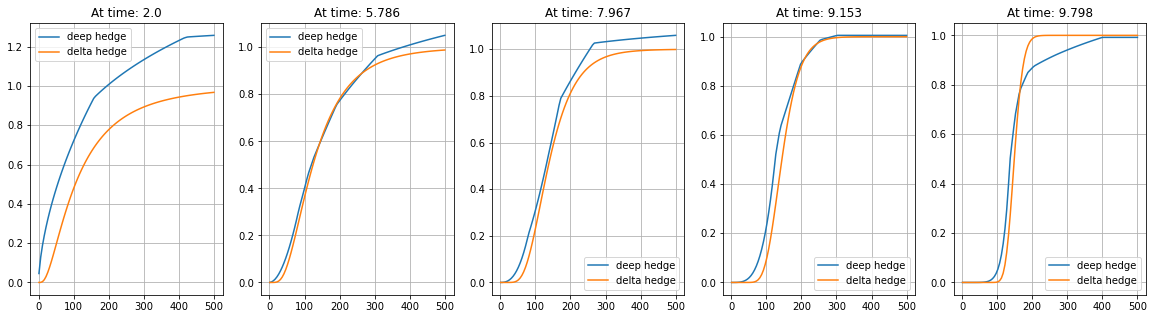

In [14]:
model = EfficientHedgeCall(np.inf, False)
model.generate_data()
model.plot_payoff()
model.build_model()
model.prepare_data()
model.train(30)
model.predict()
model.compare_strategy()

replicate wealth: 36.85
initial wealth: 22.94
ratio: 0.6225


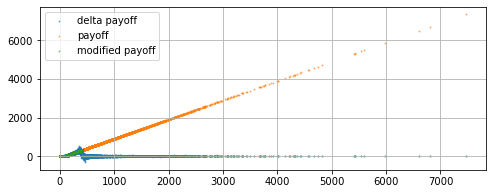

Epoch 1/30
196/196 [==============================] - 3s 15ms/step - loss: 2.3977 - p-loss: 0.5486 - 0-ad-loss: 1.8427
Epoch 2/30
196/196 [==============================] - 3s 15ms/step - loss: 0.5624 - p-loss: 0.5625 - 0-ad-loss: 5.3593e-06
Epoch 3/30
196/196 [==============================] - 3s 14ms/step - loss: 0.5623 - p-loss: 0.5623 - 0-ad-loss: 3.2631e-06
Epoch 4/30
196/196 [==============================] - 3s 14ms/step - loss: 0.5622 - p-loss: 0.5619 - 0-ad-loss: 1.2292e-05
Epoch 5/30
196/196 [==============================] - 3s 15ms/step - loss: 0.5618 - p-loss: 0.5617 - 0-ad-loss: 5.1961e-06
Epoch 6/30
196/196 [==============================] - 3s 15ms/step - loss: 0.5616 - p-loss: 0.5614 - 0-ad-loss: 1.9146e-06
Epoch 7/30
196/196 [==============================] - 3s 16ms/step - loss: 0.5615 - p-loss: 0.5613 - 0-ad-loss: 0.0000e+00
Epoch 8/30
196/196 [==============================] - 3s 16ms/step - loss: 0.5613 - p-loss: 0.5615 - 0-ad-loss: 0.0000e+00
Epoch 9/30
196/196 [

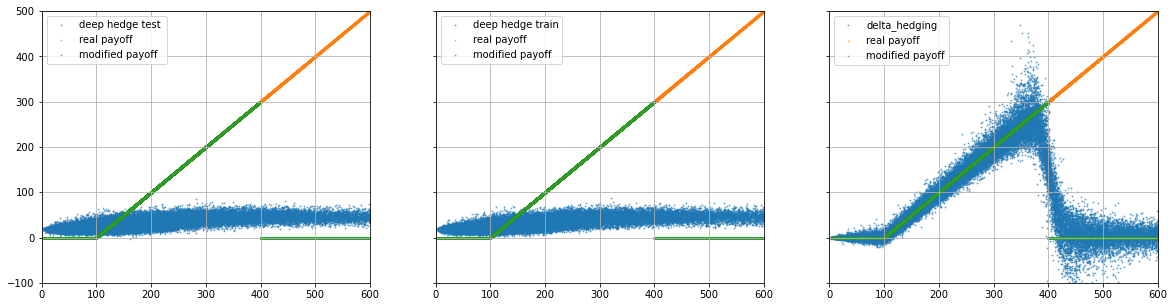

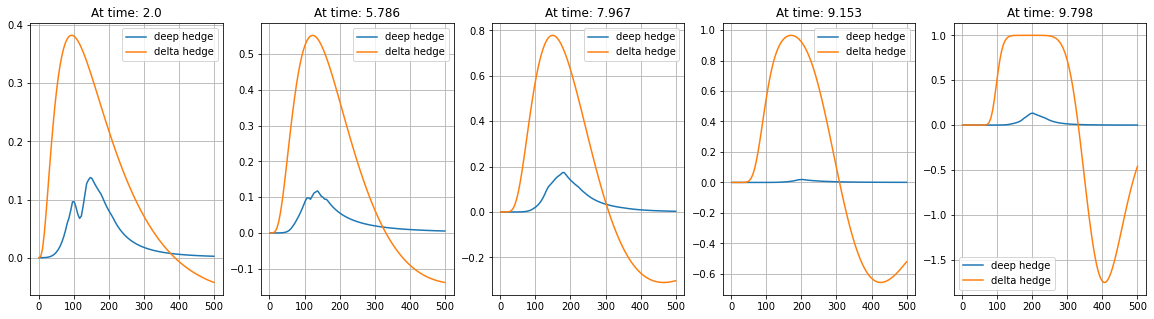

In [8]:
model = EfficientHedgeCall(0, False)
model.generate_data()
model.plot_payoff()
model.build_model()
model.prepare_data()
model.train(30)
model.predict()
model.compare_strategy()